In [28]:
# prelude
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# -----------------------------------------------------------------------------
from pathlib import Path
# k_CurrentDir  = Path(__file__).parent    # __file__ is not known in Jupyter context
k_Current_dir   = Path.cwd()
k_AssetsDir     = "assets"
k_Gold          = 1.618         # gold number for ratio
k_Width         = 12
k_Height        = k_Width/k_Gold
k_WidthPx       = 1024
k_HeightPx      = k_WidthPx/k_Gold
k_random_state  = 0

# getaround project

* https://app.jedha.co/course/project-deployment-ft/getaround-analysis-ft

# <span style="color:red"><b>TODO & Ideas - TO BE COMMENTED</b></span>

* ~~create figures with powerpoint to illustrate~~
* replace ``delay_at_checkout_in_minutes`` with slices of 5, 15, 30 and 60... minutes of delay 
    * the idea is to simplify the analysis 
    * then remove ``delay_at_checkout_in_minutes`` ? 
    * use the length of the slice as an hyperparameter and see how it helps to fight overfit ?

# Specifications (summary)

|field name	                                  |  Comment        |
|---------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------|
|rental_id	                                  |  Unique identifier of the rental|
|car_id	                                      |  Unique identifier of the car |
|checkin_type	                              |  Flow used for both checkin and checkout. (ie. access and return the car) <br> mobile = rental agreement signed on the owner's smartphone <br> connect = car equiped with the Connect technology , opened by the driver with his smartphone <br> Note: paper contracts were excluded from the data as we have no data on their delay at checkout and it's negligible use case |
|state	                                      |  canceled means that the rental did not happen (was canceled by the driver or the owner).
|delay_at_checkout_in_minutes	              |  Difference in minutes between the rental end time requested by the driver when booking the car and the actual time the driver completed the checkout. Negative values mean that the driver returned the car in advance.
|previous_ended_rental_id	                  |  id of the previous ended rental of the car (NULL when no previous rental or delay with previous rental higher than 12 hours)
|time_delta_with_previous_rental_in_minutes	  |  Difference in minutes between this rental planned start time and the previous rental planned end time (when lower than 12 hours, NULL if higher)


Questions from the product manager : 

* How often are drivers late for the next check-in? How does it impact the next driver?
* How many rentals would be affected by the feature depending on the threshold and scope we choose?
* How many problematic cases will it solve depending on the chosen threshold and scope?
* Which share of our owner’s revenue would potentially be affected by the feature?

# EDA (Delay Analysis)

In [29]:
# -----------------------------------------------------------------------------
def remove_Outliers_IQR(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[((df[column] >= lower_bound) & (df[column] <= upper_bound)) | df[column].isna()]
    return df


# -----------------------------------------------------------------------------
def remove_Outliers_Sigma(df, column):
    mean_col = df[column].mean()
    sigma_col = df[column].std()

    lower_bound = mean_col - 3 * sigma_col
    upper_bound = mean_col + 3 * sigma_col
    df = df[((df[column] >= lower_bound) & (df[column] <= upper_bound)) | df[column].isna()]
    return df

# -----------------------------------------------------------------------------
# method = "IQR" or "sigma"
def remove_Outliers(df, column, method="sigma"):
    match method:
        case "IQR":
            df = remove_Outliers_IQR(df, column)
        case "sigma":
            df = remove_Outliers_Sigma(df, column)
        case _:
            raise Exception("method must be IQR or sigma")    
    
    return df

# print(df.shape)
# for col in col_outliers:
#     df = remove_Outliers(df, col, method="sigma")
# print(df.shape)

In [30]:
# df = pd.read_excel('https://full-stack-assets.s3.eu-west-3.amazonaws.com/Deployment/get_around_delay_analysis.xlsx')
df = pd.read_excel(k_Current_dir/k_AssetsDir/"get_around_delay_analysis.xlsx", sheet_name="rentals_data")

print(f"\n\nPreview of the dataset :")
display(df.sample(20))



Preview of the dataset :


,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes,Unnamed: 7
10662,573874,405420,mobile,ended,-11.0,NaN,NaN,NaN
17978,561181,383002,mobile,canceled,NaN,NaN,NaN,NaN
19076,564710,400184,mobile,ended,NaN,NaN,NaN,NaN
18265,539272,376001,mobile,ended,NaN,NaN,NaN,NaN
19311,559257,398849,mobile,ended,NaN,NaN,NaN,NaN
484,551081,341630,mobile,ended,731.0,549811.0,690.0,NaN
1027,522370,404073,mobile,ended,307.0,NaN,NaN,NaN
14530,565057,292626,mobile,ended,-113.0,NaN,NaN,NaN
16554,546958,405005,connect,canceled,NaN,546959.0,570.0,NaN
9545,539551,384040,connect,ended,-1.0,NaN,NaN,NaN


In [31]:
print(f"\n\n% of missing values :")
display(round(df.isnull().sum()/len(df)*100, 2))




% of missing values :


rental_id                                      0.00
car_id                                         0.00
checkin_type                                   0.00
state                                          0.00
delay_at_checkout_in_minutes                  23.29
previous_ended_rental_id                      91.36
time_delta_with_previous_rental_in_minutes    91.36
Unnamed: 7                                    99.66
dtype: float64

### <span style="color:orange"><b>Comments :</b></span>
* 90% of the rentals happen more than 12 hours before the current one 


In [32]:
# -----------------------------------------------------------------------------
def preprocessor(df):
    # drop
    df.drop(columns="Unnamed: 7", inplace=True)
    df.drop_duplicates(inplace=True)

    # format 
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace("/", "_")
    
    # cast 
    df['rental_id'] = df['rental_id'].astype(str)
    df['car_id'] = df['car_id'].astype(str)
    # df['previous_ended_rental_id'] = df['previous_ended_rental_id'].astype(str)
    df['previous_ended_rental_id'] = df['previous_ended_rental_id'].apply(lambda x: str(int(x)) if not pd.isna(x) else x)


    # other preprocessing should come here
    # df["time_slot"] = (df["hour"]*60 + df["minute"])//k_time_slot_len

    return df

In [33]:
df = preprocessor(df)
print(f"\n\nPreview of the preprocessed dataset :")
display(df.head())



Preview of the preprocessed dataset :


,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
0,532240,379042,mobile,ended,71084.0,NaN,NaN
1,549980,402829,mobile,ended,64059.0,NaN,NaN
2,537546,408750,mobile,ended,37382.0,NaN,NaN
3,534699,270195,mobile,ended,23126.0,NaN,NaN
4,556557,413591,mobile,ended,22618.0,NaN,NaN


In [34]:
# -----------------------------------------------------------------------------
def quick_View(df: pd.DataFrame) -> pd.DataFrame:

    """
    Generates a summary DataFrame for each column in the input DataFrame.

    This function analyzes each column in the given DataFrame and creates a summary that includes
    data type, number of null values, percentage of null values, number of non-null values, 
    number of distinct values, min and max values, outlier bounds (for numeric columns),
    and the frequency of distinct values.

    Args:
        df (pd.DataFrame): The input DataFrame to analyze.

    Returns:
        pd.DataFrame: A DataFrame containing the summary of each column from the input DataFrame. 
                      Each row in the resulting DataFrame represents a column from the input DataFrame
                      with the following information:
                      - "name": Column name
                      - "dtype": Data type of the column
                      - "# null": Number of null values
                      - "% null": Percentage of null values
                      - "# NOT null": Number of non-null values
                      - "distinct val": Number of distinct values
                      - "-3*sig": Lower bound for outliers (mean - 3*std) for numeric columns
                      - "min": Minimum value for numeric columns
                      - "mean" : Mean value for numeric columns
                      - "max": Maximum value for numeric columns
                      - "+3*sig": Upper bound for outliers (mean + 3*std) for numeric columns
                      - "distinct val count": Dictionary of distinct value counts or top 10 values for object columns
    """

    summary_lst = []
  
    for col_name in df.columns:
        col_dtype               = df[col_name].dtype
        num_of_null             = df[col_name].isnull().sum()
        percent_of_null         = num_of_null/len(df)
        num_of_non_null         = df[col_name].notnull().sum()
        num_of_distinct_values  = df[col_name].nunique()

        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts    = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts  = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        if col_dtype != "object":
            max_of_col  = df[col_name].max()
            min_of_col  = df[col_name].min()
            mean_of_col = df[col_name].mean()
            outlier_hi  = df[col_name].mean() + 3*df[col_name].std()
            outlier_lo  = df[col_name].mean() - 3*df[col_name].std()
        else:
            max_of_col = -1
            min_of_col =  1
            mean_of_col = np.nan
            outlier_hi = -1
            outlier_lo =  1

        summary_lst.append({
            "name"                : col_name,
            "dtype"               : col_dtype,
            "# null"              : num_of_null,
            "% null"              : (100*percent_of_null).round(2),
            "# NOT null"          : num_of_non_null,
            "distinct val"        : num_of_distinct_values,
            "-3*sig"              : round(outlier_lo,2) ,
            "min"                 : round(min_of_col,2),
            "mean"                : round(mean_of_col,2),
            "max"                 : round(max_of_col,2),
            "+3*sig"              : round(outlier_hi,2) ,
            "distinct val count"  : distinct_values_counts
        })

    df_tmp = pd.DataFrame(summary_lst)
    return df_tmp

In [35]:
print(f"\n\nThe dataset consists of :")
print(f"\t{len(df.shape):>9_} dimensions")
print(f"\t{df.shape[0]:>9_} observations")
print(f"\t{df.shape[1]:>9_} features    ")

df_types = pd.DataFrame ({
  "types" : df.dtypes.value_counts()
})
df_types["as_%"] = (100 * df_types["types"]/df_types["types"].sum()).round(2)

print(f"\n\n% of data type :")
display(df_types)

df_tmp = quick_View(df)
print(f"\n\nQuickView :")
display(df_tmp.sort_values(by="# null", ascending=False))   





The dataset consists of :
	        2 dimensions
	   21_310 observations
	        7 features    


% of data type :


,types,as_%
object,5,71.43
float64,2,28.57




QuickView :


,name,dtype,# null,% null,# NOT null,distinct val,-3*sig,min,mean,max,+3*sig,distinct val count
5,previous_ended_rental_id,object,19469,91.36,1841,1788,1.00,1.0,NaN,-1.0,-1.00,"{'537243': 4, '547969': 3, '541079': 3, '54657..."
6,time_delta_with_previous_rental_in_minutes,float64,19469,91.36,1841,25,-484.50,0.0,279.29,720.0,1043.07,"{0.0: 279, 60.0: 183, 120.0: 137, 720.0: 130, ..."
4,delay_at_checkout_in_minutes,float64,4964,23.29,16346,1745,-2947.98,-22433.0,59.70,71084.0,3067.39,"{4.0: 165, 6.0: 152, 2.0: 151, 7.0: 150, 9.0: ..."
0,rental_id,object,0,0.00,21310,21310,1.00,1.0,NaN,-1.0,-1.00,"{'532240': 1, '522106': 1, '568794': 1, '53869..."
1,car_id,object,0,0.00,21310,8143,1.00,1.0,NaN,-1.0,-1.00,"{'334190': 33, '241021': 29, '392479': 29, '34..."
2,checkin_type,object,0,0.00,21310,2,1.00,1.0,NaN,-1.0,-1.00,"{'mobile': 17003, 'connect': 4307}"
3,state,object,0,0.00,21310,2,1.00,1.0,NaN,-1.0,-1.00,"{'ended': 18045, 'canceled': 3265}"


### <span style="color:orange"><b>Comments :</b></span>
* Only 2 values for ``checkin_type`` and ``state`` 
* There are "only" 25 uniques value in `time_delta_with_previous_rental_in_minutes` 
* Many outliers in ``delay_at_checkout_in_minutes``

### checkin_type :

Nb mobile  :  17_003
Nb connect :   4_307


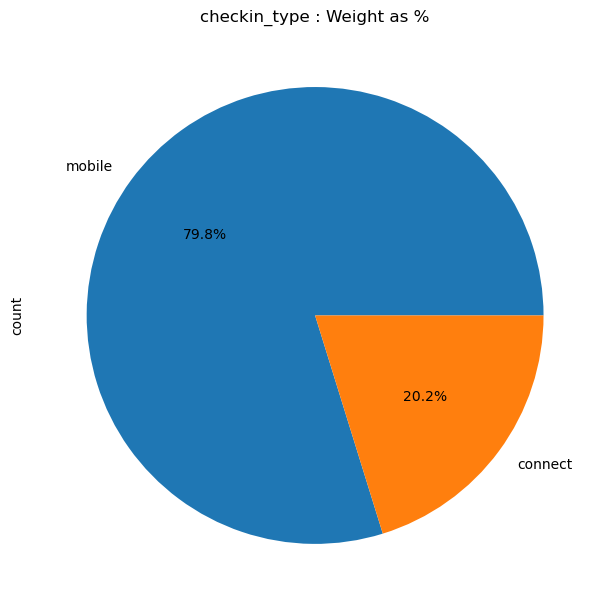

In [36]:
counts = df["checkin_type"].value_counts()
print(f"Nb mobile  : {counts['mobile']:>7_}")
print(f"Nb connect : {counts['connect']:>7_}")

_ = counts.plot.pie(title="checkin_type : Weight as %", autopct="%1.1f%%", figsize=(k_Width, k_Height))

### <span style="color:orange"><b>Comments :</b></span>
* 20% of the checkin/checkout are made via connected cars  


### state :

Nb ended    :  18_045
Nb canceled :   3_265


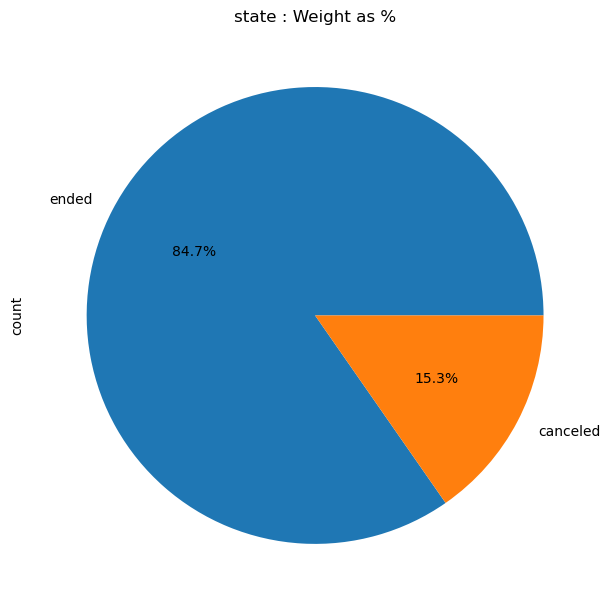

In [37]:
counts = df["state"].value_counts()
print(f"Nb ended    : {counts['ended']:>7_}")
print(f"Nb canceled : {counts['canceled']:>7_}")

_ = counts.plot.pie(title="state : Weight as %", autopct="%1.1f%%", figsize=(k_Width, k_Height))

### <span style="color:orange"><b>Comments :</b></span>
* 15% of the rentals are canceled  


### time_delta_with_previous_rental_in_minutes :

In [38]:
print("Unique values in time_delta_with_previous_rental_in_minutes : ")
display(sorted(df["time_delta_with_previous_rental_in_minutes"].unique()))

Unique values in time_delta_with_previous_rental_in_minutes : 


[nan,
 0.0,
 30.0,
 60.0,
 90.0,
 120.0,
 150.0,
 180.0,
 210.0,
 240.0,
 270.0,
 300.0,
 330.0,
 360.0,
 390.0,
 420.0,
 450.0,
 480.0,
 510.0,
 540.0,
 570.0,
 600.0,
 630.0,
 660.0,
 690.0,
 720.0]

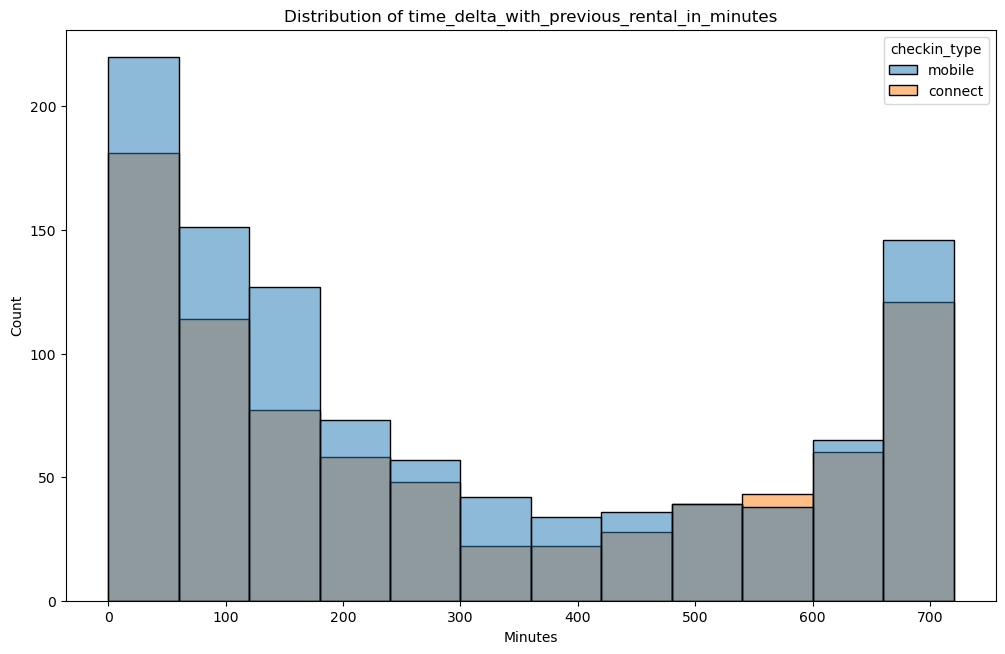

In [39]:
fig, ax = plt.subplots(figsize=(k_Width,k_Height))
sns.histplot(data=df, x="time_delta_with_previous_rental_in_minutes", hue="checkin_type") #, bins=100, , kde=True

ax.set_title("Distribution of time_delta_with_previous_rental_in_minutes")
ax.set_xlabel("Minutes")
# ax.set_xlim(-2000, 2000)
plt.show()

### delay_at_checkout_in_minutes :

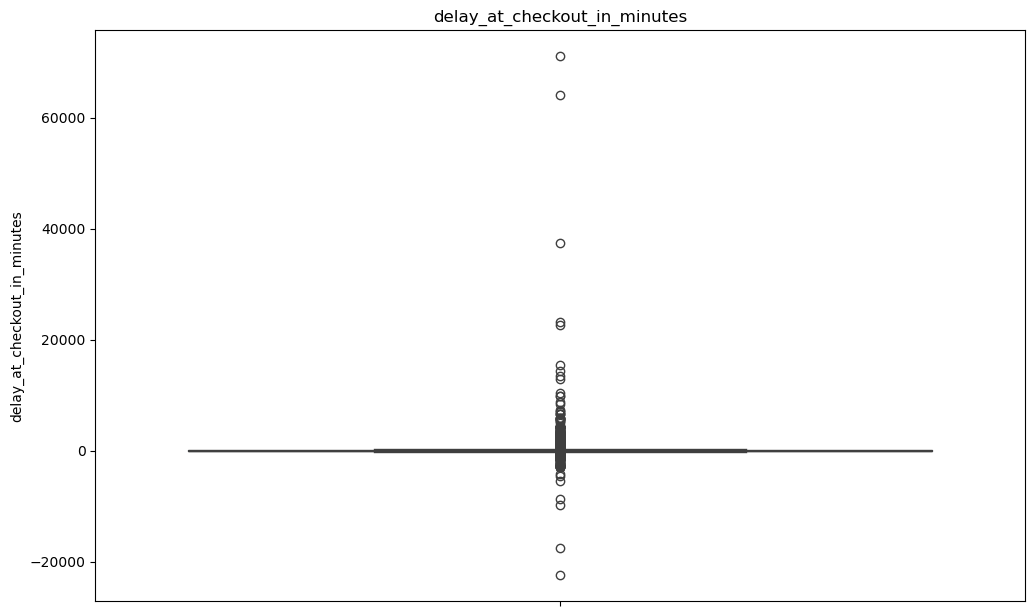

In [40]:
fig, ax = plt.subplots(figsize=(k_Width,k_Height))
sns.boxplot(df, y="delay_at_checkout_in_minutes", legend=False)                  #palette=palette_gender, hue="gender" ,  
plt.title("delay_at_checkout_in_minutes")
plt.show()

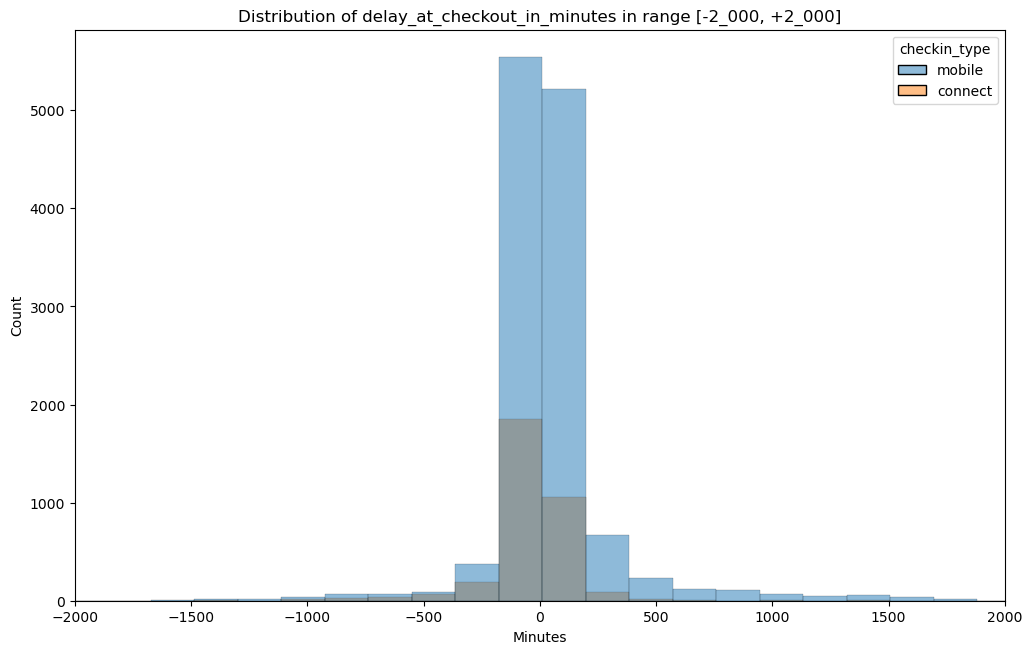

In [41]:
fig, ax = plt.subplots(figsize=(k_Width,k_Height))
sns.histplot(data=df, x="delay_at_checkout_in_minutes", hue="checkin_type", bins=500) #, bins=100, , kde=True

ax.set_title("Distribution of delay_at_checkout_in_minutes in range [-2_000, +2_000]")
ax.set_xlabel("Minutes")
ax.set_xlim(-2000, 2000)
plt.show()

# How often are drivers late for the next check-in? How does it impact the next driver?

<p align="center">
<img src="./assets/no_treshold.png" alt="drawing" width="800"/>
<p> 


In [42]:
print(f"Late returns         : {round(len(df[df['delay_at_checkout_in_minutes']>0])/len(df)*100, 2)} %")
print(f"On time returns      : {round(len(df[df['delay_at_checkout_in_minutes']<=0])/len(df)*100, 2)} %")
print(f"Returns without info : {round(df['delay_at_checkout_in_minutes'].isna().sum()/len(df)*100, 2)} %")



Late returns         : 44.13 %
On time returns      : 32.58 %
Returns without info : 23.29 %


### <span style="color:orange"><b>Comments :</b></span>
* Only 1/3 of the returns are either on time or in advance
* 1/4 of the returns with <span style="color:red"><b>NO</b></span> data ?
* We should first focus on getting more delay information
    * Proposal : A car should not be be displayed in the search results as long as the info about `delay_at_checkout_in_minutes` in not filled


In [43]:
labels_in_order = ['On time', '0-10 min', '10-30 min', '30 min-1H', '1H-2H', '2H-6H', '> 6H']

categories = pd.cut(
    df['delay_at_checkout_in_minutes'], 
    bins=[-float('inf'), 0, 10, 30, 60, 120, 360, float('inf')],
    labels = labels_in_order
)

df['cat_delay'] = categories
# df.sample(20)

print(f"Returns :")
print(f"No info      {round(df['delay_at_checkout_in_minutes'].isna().sum()/len(df)*100, 2)}")
print(round(df['cat_delay'].value_counts()/len(df)*100, 2))


Returns :
No info      23.29
cat_delay
On time      32.58
10-30 min     8.93
1H-2H         8.60
30 min-1H     7.94
2H-6H         7.83
0-10 min      6.68
> 6H          4.15
Name: count, dtype: float64


In [44]:
df_tmp = pd.DataFrame(round(df['cat_delay'].value_counts()/len(df)*100, 2)).reset_index()
df_tmp.columns = ['cat_delay', 'delay_%']

df_tmp['cat_delay'] = pd.Categorical(df_tmp['cat_delay'], categories=labels_in_order, ordered=True)
df_tmp.sort_values('cat_delay', inplace=True)
df_tmp.set_index('cat_delay', inplace=True)
print(df_tmp)

           delay_%
cat_delay         
On time      32.58
0-10 min      6.68
10-30 min     8.93
30 min-1H     7.94
1H-2H         8.60
2H-6H         7.83
> 6H          4.15


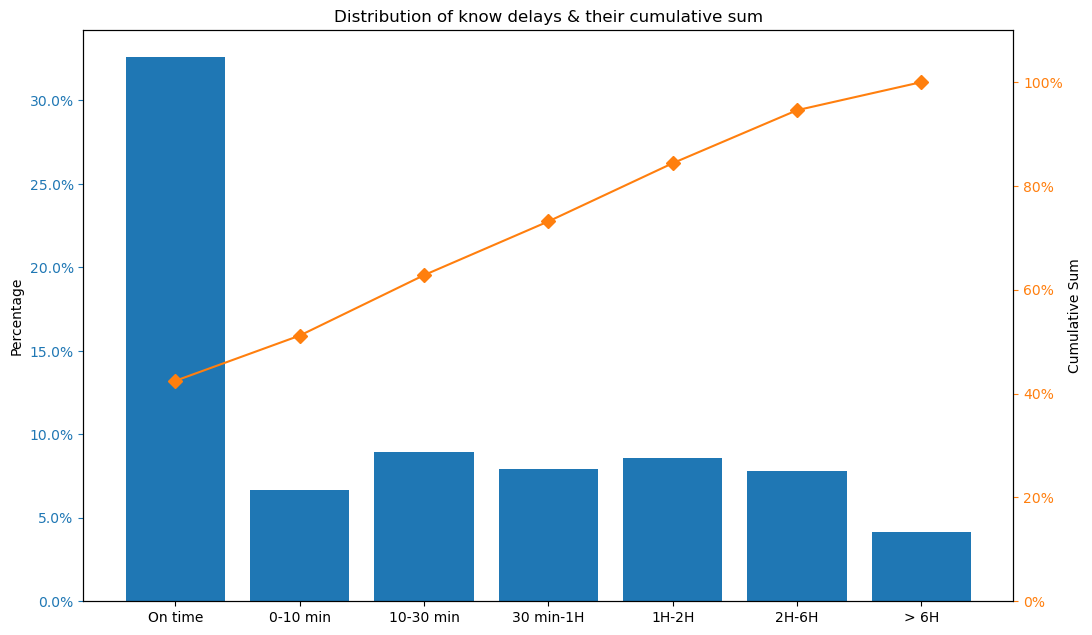

In [45]:
df_tmp["cum_percent"] = df_tmp["delay_%"].cumsum()/df_tmp["delay_%"].sum()*100

fig, ax = plt.subplots(figsize=(k_Width,k_Height))
ax.bar(df_tmp.index, df_tmp["delay_%"], color="C0")
ax.yaxis.set_major_formatter(PercentFormatter())
ax.set_ylabel('Percentage')
ax.tick_params(axis="y", colors="C0")
ax.set_title("Distribution of known delays & their cumulative sum")

ax2 = ax.twinx()
ax2.plot(df_tmp.index, df_tmp["cum_percent"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.set_ylabel('Cumulative sum')
ax2.set(ylim=(0, 110))
ax2.tick_params(axis="y", colors="C1")

plt.show()

Let's focus on the delays only

           delay_%
cat_delay         
0-10 min     15.14
10-30 min    20.23
30 min-1H    17.99
1H-2H        19.49
2H-6H        17.74
> 6H          9.41


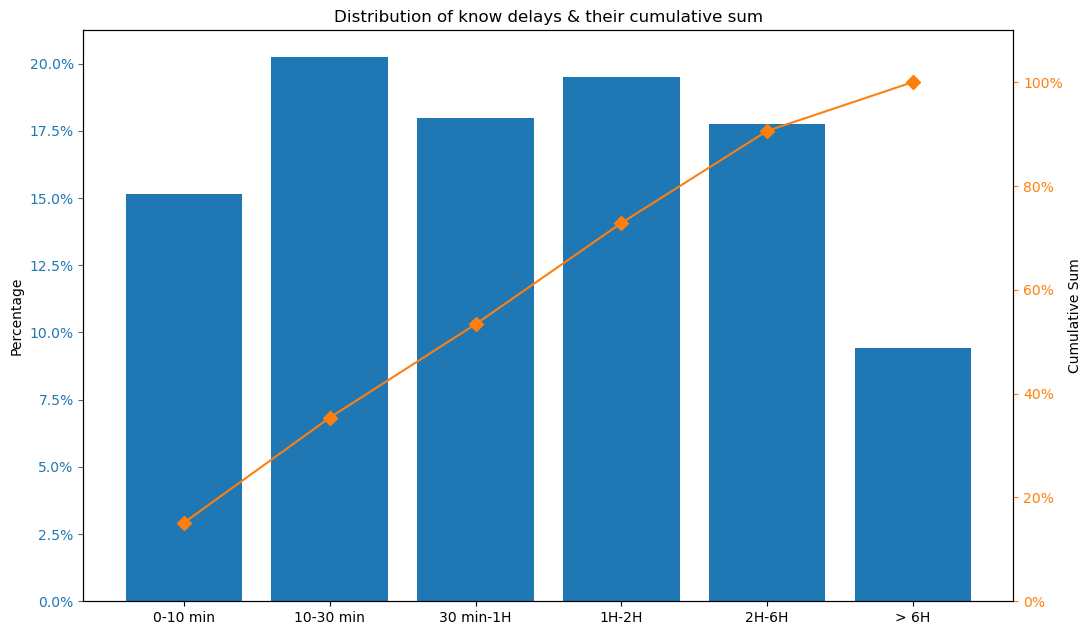

In [58]:
labels_in_order = ['0-10 min', '10-30 min', '30 min-1H', '1H-2H', '2H-6H', '> 6H']

categories = pd.cut(
    df['delay_at_checkout_in_minutes'], 
    bins=[0, 10, 30, 60, 120, 360, float('inf')],
    labels = labels_in_order
)
df['cat_delay'] = categories

df_tmp = pd.DataFrame(round(df['cat_delay'].value_counts()/len(df[df["delay_at_checkout_in_minutes"]>0])*100, 2)).reset_index()
df_tmp.columns = ['cat_delay', 'delay_%']

df_tmp['cat_delay'] = pd.Categorical(df_tmp['cat_delay'], categories=labels_in_order, ordered=True)
df_tmp.sort_values('cat_delay', inplace=True)
df_tmp.set_index('cat_delay', inplace=True)
print(df_tmp)

df_tmp["cum_percent"] = df_tmp["delay_%"].cumsum()/df_tmp["delay_%"].sum()*100

fig, ax = plt.subplots(figsize=(k_Width,k_Height))
ax.bar(df_tmp.index, df_tmp["delay_%"], color="C0")
ax.yaxis.set_major_formatter(PercentFormatter())
ax.set_ylabel('Percentage')
ax.tick_params(axis="y", colors="C0")
ax.set_title("Distribution of positives known delays & their cumulative sum")

ax2 = ax.twinx()
ax2.plot(df_tmp.index, df_tmp["cum_percent"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.set_ylabel('Cumulative sum')
ax2.set(ylim=(0, 110))
ax2.tick_params(axis="y", colors="C1")

plt.show()


### <span style="color:orange"><b>Comments :</b></span>
* More than 50% of the known delays are below 1H
* Almost 80% of the known delays are below 2H
* But, again, 1/4 of the returns comes with no information about the delay


How the delay impact the next driver ?
 
<p align="center">
<img src="./assets/no_treshold.png" alt="drawing" width="800"/>
<p> 


In [88]:
# total number of reservations with a positive delay_at_checkout_in_minutes 
n1 = len(df[(df['delay_at_checkout_in_minutes'] > 0 )])
print(n1)

# number of bookings with a delay_at_checkout_in_minutes greater than the allowed delay time 
# If time_delta_with_previous_rental_in_minutes exiists this means there was a previous booking
n2 = len(df[(df['delay_at_checkout_in_minutes'] > df['time_delta_with_previous_rental_in_minutes']) ])             
print (n2)

print(f"Among all the late returns, {round(n2/n1*100, 2)} % of them are problematic")
print(f"Indeed the checkout happened after the allowed delay time")


9404
270
Among all the late returns, 2.87 % of them are problematic
Indeed the checkout happened after the allowed delay time


In [92]:
# total number of reservations with a positive delay_at_checkout_in_minutes AND 
n1 = len(df[(df['delay_at_checkout_in_minutes'] > 0 ) & (df['previous_ended_rental_id'].notna())])
print(n1)

# number of bookings with a previous rental AND a delay_at_checkout_in_minutes greater than the allowed delay time 
n2 = len(df[(df['delay_at_checkout_in_minutes'] > df['time_delta_with_previous_rental_in_minutes']) ])              #  
print (n2)

print(f"Among all the late returns between 2 consecutive bookings, {round(n2/n1*100, 2)} % of them are problematic")
print(f"Indeed the checkout happened after the allowed delay time")


802
270
Among all the late returns between 2 consecutive bookings, 33.67 % of them are problematic
Indeed the checkout happened after the allowed delay time


# How many rentals would be affected by the feature depending on the threshold and scope we choose?


<p align="center">
<img src="./assets/with_treshold.png" alt="drawing" width="800"/>
<p> 


In [93]:
threshold = 60

# number of reservations with delay_at_checkout_in_minutes > 0
n1 = len(df[(df['delay_at_checkout_in_minutes'] > threshold )])
print(n1)


# number of bookings with a delay_at_checkout_in_minutes greater than the allowed delay time + threshold
n2 = len(df[(df['delay_at_checkout_in_minutes'] > 0)])
print(n2)



# print(len(df[(df['delay_at_checkout_in_minutes'] > threshold)]))             #  & (df['previous_ended_rental_id'].notna())
# print(f"With a treshold of {threshold} minutes, {round(len(df[(df['delay_at_checkout_in_minutes'] > threshold + df['time_delta_with_previous_rental_in_minutes'])]) / len(df[(df['delay_at_checkout_in_minutes'] > 0 )]) * 100, 2)} % remain problematic")
print(f"With a treshold of {threshold} minutes, {round(n1/n2 * 100, 2)} % remain problematic")


4386
9404
With a treshold of 60 minutes, 46.64 % remain problematic


In [ ]:
problematic_rates = []

for threshold in thresholds:
    # Filter data for delays exceeding the threshold
    delayed_rentals = delay_data[delay_data['delay_at_checkout_in_minutes'] > threshold]

    # Calculate the percentage of problematic delays for each threshold
    problematic_rate = (len(delayed_rentals) / len(delay_data)) * 100
    problematic_rates.append(problematic_rate)

# Create a line plot to visualize the impact of different thresholds
fig = px.line(x=thresholds, y=problematic_rates, markers=True, title='Impact of Delay Threshold on Problematic Delays')
fig.update_layout(xaxis_title='Delay Threshold (minutes)', yaxis_title='Percentage of Problematic Delays')
fig.show()

# How many problematic cases will it solve depending on the chosen threshold and scope?


# Which share of our owner’s revenue would potentially be affected by the feature?

# <span style="color:red"><b>Scrap book - Please ignore</b></span>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

df = pd.DataFrame({'country': [177.0, 7.0, 4.0, 2.0, 2.0, 1.0, 1.0, 1.0]})
df.index = ['USA', 'Canada', 'Russia', 'UK', 'Belgium', 'Mexico', 'Germany', 'Denmark']
df = df.sort_values(by='country',ascending=False)
df["cum_percent"] = df["country"].cumsum()/df["country"].sum()*100


fig, ax = plt.subplots()
ax.bar(df.index, df["country"], color="C0")
ax2 = ax.twinx()
ax2.plot(df.index, df["cum_percent"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
plt.show()

In [ ]:
import pandas as pd

df = pd.DataFrame({
    'couleurs': ['rouge', 'vert', 'bleu', 'rouge', 'bleu'],
    'valeurs': [10, 20, 30, 40, 50]
})

order = ['bleu', 'rouge', 'vert']

df['couleurs'] = pd.Categorical(df['couleurs'], categories=order, ordered=True)
df.sort_values('couleurs', inplace=True)
print(df)

In [ ]:
df_tmp = pd.DataFrame({'Delay': [23.29, 32.58, 3.30, 6.03, 6.28, 7.94, 8.60, 11.10, 0.88]})
df_tmp.index = ['No info', 'On time', '< 5 min', '5-15 min', '15-30 min', '30 min-1H', '1H-2H', '2H-24H', '> 24H']
# df_tmp = df_tmp.sort_values(by='Delay',ascending=False)
df_tmp["cum_percent"] = df_tmp["Delay"].cumsum()/df_tmp["Delay"].sum()*100


fig, ax = plt.subplots(figsize=(k_Width,k_Height))
ax.bar(df_tmp.index, df_tmp["Delay"], color="C0")
ax2 = ax.twinx()
ax2.plot(df_tmp.index, df_tmp["cum_percent"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
plt.show()

In [ ]:
df_tmp = pd.DataFrame({'Delay': [3.30, 6.03, 6.28, 7.94, 8.60, 11.10, 0.88]})
df_tmp.index = ['< 5 min', '5-15 min', '15-30 min', '30 min-1H', '1H-2H', '2H-24H', '> 24H']
# df_tmp = df_tmp.sort_values(by='Delay',ascending=False)
df_tmp["cum_percent"] = df_tmp["Delay"].cumsum()/df_tmp["Delay"].sum()*100


fig, ax = plt.subplots(figsize=(k_Width,k_Height))
ax.bar(df_tmp.index, df_tmp["Delay"], color="C0")
ax2 = ax.twinx()
ax2.plot(df_tmp.index, df_tmp["cum_percent"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
plt.show()

In [ ]:
categories = pd.cut(df['delay_at_checkout_in_minutes'], 
                    bins=[-float('inf'), 0, 5, 15, 30, 60, 120, 1440, float('inf')],
                    labels=['On time', '< 5 min', '5-15 min', '15-30 min', '30 min-1H', '1H-2H', '2H-24H', '> 24H'])

df['cat_delay'] = categories

# df.sample(20)
print(f"Returns :")
print(f"No info      {round(df['delay_at_checkout_in_minutes'].isna().sum()/len(df)*100, 2)}")
print(round(df['cat_delay'].value_counts()/len(df)*100, 2))


In [ ]:
# categories = pd.cut(df['delay_at_checkout_in_minutes'], 
#                     bins=[-float('inf'), 0, 5, 15, 30, 60, 120, 1440, float('inf')],
#                     labels=['On time', '< 5 min', '5-15 min', '15-30 min', '30 min-1H', '1H-2H', '2H-24H', '> 24H'])

# df['cat_delay'] = categories

# # df.sample(20)
# print(f"Returns :")
# print(f"No info      {round(df['delay_at_checkout_in_minutes'].isna().sum()/len(df)*100, 2)}")
# print(round(df['cat_delay'].value_counts()/len(df)*100, 2))


In [ ]:
# categories = pd.cut(df['delay_at_checkout_in_minutes'], 
#                     bins=[-float('inf'), 0, 5, 15, 30, 60, 120, 1440, float('inf')],
#                     labels=['On time', '< 5 min', '5-15 min', '15-30 min', '30 min-1H', '1H-2H', '2H-24H', '> 24H'])

# df['cat_delay'] = categories

# # df.sample(20)
# print(f"Returns :")
# print(f"No info      {round(df['delay_at_checkout_in_minutes'].isna().sum()/len(df)*100, 2)}")
# print(round(df['cat_delay'].value_counts()/len(df)*100, 2))


In [ ]:
# df_tmp = quick_View(df)
# print(f"\n\nQuickView :")
# display(df_tmp.sort_values(by="# null", ascending=False))   


In [ ]:
# tmp_df = df[df['delay_at_checkout_in_minutes']>0]

# fig, ax = plt.subplots(figsize=(k_Width,k_Height))
# sns.histplot(data=tmp_df, x="delay_at_checkout_in_minutes", bins=100) #, bins=100, , kde=True, , hue="checkin_type", bins=500
# ax.set_title("Distribution of delay_at_checkout_in_minutes in range [-2_000, +2_000]")
# ax.set_xlabel("Minutes")
# plt.show()